In [1]:
# Run this cell if running this notebook for the first time
#!pip install -U --pre segmentation-models --user 
#!conda install -c conda-forge albumentations

In [2]:
# Name experiment
experiment_name = "unet-1"

In [3]:
# Import libs
import os 
import time
import cv2
from tqdm import tqdm
import numpy as np
import skimage.draw
import random
import keras
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.io as sio
from PIL import Image
import scipy
import scipy.ndimage
import keras.backend as K
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`


def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

        
            
    
# Define paths
dataset_name = "data_processedv5"
base_path = os.path.abspath(".")
dataset_path = os.path.join(base_path, "dataset", dataset_name)
log_path = os.path.join(base_path, "logs", experiment_name)
patchsize = 80


# For full data training
full_data_path = os.path.join(base_path, "dataset")

#print(log_path)
#print(os.listdir(dataset_path))


# Make directory
create_directory(log_path)


# Get the data

# Full data
#x_train_dir = os.path.join(full_data_path, 'data_processedv4', 'images')
#y_train_dir = os.path.join(full_data_path, 'data_processedv4', 'masks')


# Training data
x_train_dir = os.path.join(dataset_path, 'train', 'images')
y_train_dir = os.path.join(dataset_path, 'train', 'masks')

# Validation data
x_valid_dir = os.path.join(dataset_path, 'val', 'images')
y_valid_dir = os.path.join(dataset_path, 'val', 'masks')

# Test data
x_test_dir = x_valid_dir 
y_test_dir = y_valid_dir 

print("Training and validation samples: ", len(os.listdir(x_train_dir)), len(os.listdir(x_valid_dir))) 

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Training and validation samples:  112466 28117


### Panoptic Quality Metric

Panoptic Segmentation
Alexander Kirillov, Kaiming He, Ross Girshick, Carsten Rother and Piotr Dollár
arXiv:1801.00868, 2018.

In [4]:
# Compute Panoptic quality metric for each image
def Panoptic_quality(ground_truth_image,predicted_image):
    TP = 0
    FP = 0
    FN = 0
    sum_IOU = 0
    matched_instances = {}# Create a dictionary to save ground truth indices in keys and predicted matched instances as velues
                        # It will also save IOU of the matched instance in [indx][1]

    # Find matched instances and save it in a dictionary
    for i in np.unique(ground_truth_image):
        if i == 0:
            pass
        else:
            temp_image = np.array(ground_truth_image)
            temp_image = temp_image == i
            matched_image = temp_image * predicted_image
        
            for j in np.unique(matched_image):
                if j == 0:
                    pass
                else:
                    pred_temp = predicted_image == j
                    intersection = sum(sum(temp_image*pred_temp))
                    union = sum(sum(temp_image + pred_temp))
                    IOU = intersection/union
                    if IOU> 0.5:
                        matched_instances [i] = j, IOU 
                        
    # Compute TP, FP, FN and sum of IOU of the matched instances to compute Panoptic Quality               
                        
    pred_indx_list = np.unique(predicted_image)
    pred_indx_list = np.array(pred_indx_list[1:])

    # Loop on ground truth instances
    for indx in np.unique(ground_truth_image):
        if indx == 0:
            pass
        else:
            if indx in matched_instances.keys():
                pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == [indx][0]))
                TP = TP+1
                sum_IOU = sum_IOU+matched_instances[indx][1]
            else:
                FN = FN+1
    FP = len(np.unique(pred_indx_list))
    PQ = sum_IOU/(TP+0.5*FP+0.5*FN)
    
    return PQ

#### Dataloader and utility functions¶

In [5]:
# Helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    
    norm=plt.Normalize(0,4) # 5 classes including BG
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)
    plt.show()
    
    
# Helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# Classes for data loading and preprocessing
class Dataset:
    """MoNuSAC Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['Epithelial', 'Lymphocyte', 'Neutrophil', 'Macrophage', 'unlabelled']

    
#    label_map = {'Epithelial':1, RED
#             'Lymphocyte':2, YELLOW
#             'Macrophage':4, GREEN
#             'Neutrophil':3, BLUE
#            }
    
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        
        # Unsorted
        #self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        #self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # Sorted
        self.images_fps = sorted([os.path.join(images_dir, image_id) for image_id in self.ids])
        self.masks_fps = sorted([os.path.join(masks_dir, image_id) for image_id in self.ids])

        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes] # cls used instead of cls.lower()

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # Read data
        
        #image = cv2.imread(self.images_fps[i])
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = skimage.io.imread(self.images_fps[i])
        
        #mask = cv2.imread(self.masks_fps[i], 0)
        mask = skimage.io.imread(self.masks_fps[i])
        


        # Extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # Add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


### Test the dataset class 

['0.png', '1.png', '10.png'] ['0.png', '1.png', '10.png']
Index:  60755
(80, 80, 3) (80, 80)
Ground truth classes:  [0 1]


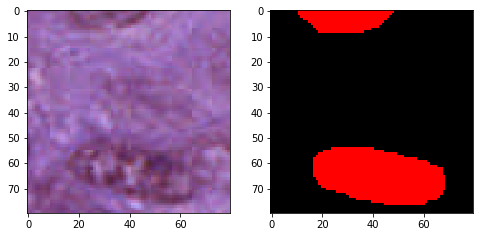

In [6]:
# Load a random image from the images folder
image_fns = sorted(next(os.walk(x_train_dir))[2])
gt_fns = sorted(next(os.walk(y_train_dir))[2])
print(image_fns[:3], gt_fns[:3])

# Get random number
idx = random.randrange(len(image_fns)) # 94 
print("Index: ", idx)


# Read image and mask
image = skimage.io.imread(os.path.join(x_train_dir, image_fns[idx]))
gt = skimage.io.imread(os.path.join(y_train_dir, gt_fns[idx]))

# Flags
assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
assert image.dtype == gt.dtype, "Wrong data types!"

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

#label_map = {'Epithelial':1, RED
#             'Lymphocyte':2, YELLOW
#             'Macrophage':4, GREEN
#             'Neutrophil':3, BLUE
#            }

import matplotlib.colors
# Stolen from https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale 
norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

f, axarr = plt.subplots(1,2, figsize=(8,8))

# idx = 94 all classes

axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

(80, 80, 3) (80, 80, 5)


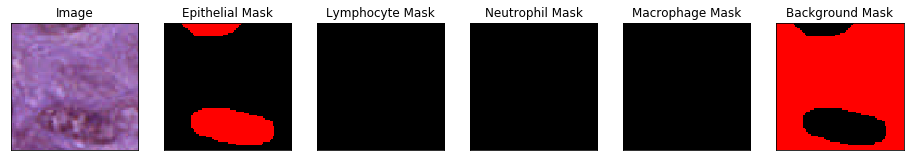

In [7]:
# One image and mask

#label_map = {'Epithelial':1,
#         'Lymphocyte':2,
#         'Macrophage':4,
#         'Neutrophil':3,
#        }

med = ['Epithelial', 'Lymphocyte', 'Neutrophil', 'Macrophage']

dataset = Dataset(x_train_dir, y_train_dir, classes=med)
image, mask = dataset[idx] 

print(image.shape, mask.shape)
visualize(
    image=image, 
    Epithelial_mask = mask[..., 1].squeeze(),
    Lymphocyte_mask = mask[..., 2].squeeze(),
    Neutrophil_mask = mask[..., 3].squeeze(),
    Macrophage_mask = mask[..., 4].squeeze(),
    background_mask = mask[..., 0].squeeze(),
)

(80, 80, 3) (80, 80, 5)


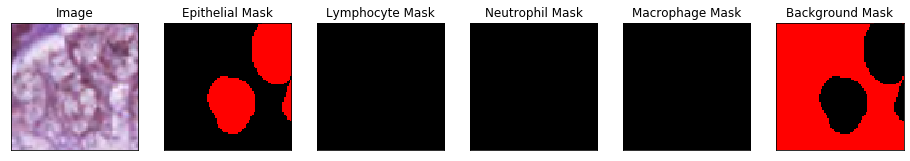

(80, 80, 3) (80, 80, 5)


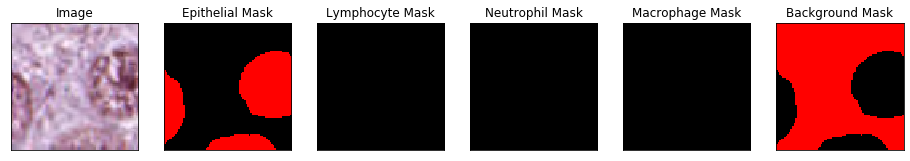

(80, 80, 3) (80, 80, 5)


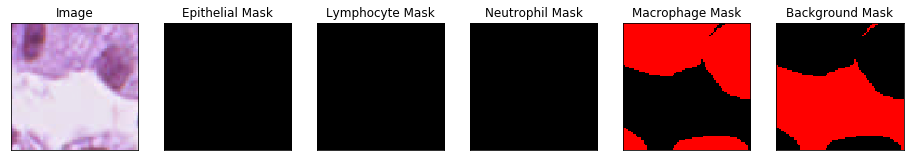

In [8]:
#label_map = {'Epithelial':1,
#         'Lymphocyte':2,
#         'Macrophage':4,
#         'Neutrophil':3,
#        }

med = ['Epithelial', 'Lymphocyte', 'Neutrophil', 'Macrophage']

dataset = Dataset(x_train_dir, y_train_dir, classes=med)

for i in range(3):
    
    image, mask = dataset[random.randrange(len(dataset))] # get some sample
    print(image.shape, mask.shape)
    
    visualize(
        image=image, 
        Epithelial_mask = mask[..., 1].squeeze(),
        Lymphocyte_mask = mask[..., 2].squeeze(),
        Neutrophil_mask = mask[..., 3].squeeze(),
        Macrophage_mask = mask[..., 4].squeeze(),
        background_mask = mask[..., 0].squeeze(),
    )


#### Augmentations

    horizontal flip
    affine transforms
    perspective transforms
    brightness/contrast/colors manipulations
    image bluring and sharpening
    gaussian noise
    random crops

In [9]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=patchsize, min_width=patchsize, always_apply=True, border_mode=0), # patchsize instead of 320
        A.RandomCrop(height=patchsize, width=patchsize, always_apply=True), # patchsize instead of 320

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 80"""
    test_transform = [
        A.PadIfNeeded(patchsize, patchsize)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/home/hasib/anaconda3/envs/isbi2020/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


(80, 80, 3) (80, 80, 5)


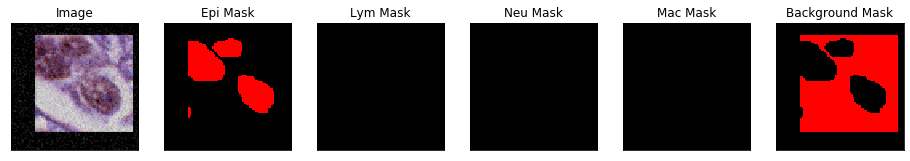

(80, 80, 3) (80, 80, 5)


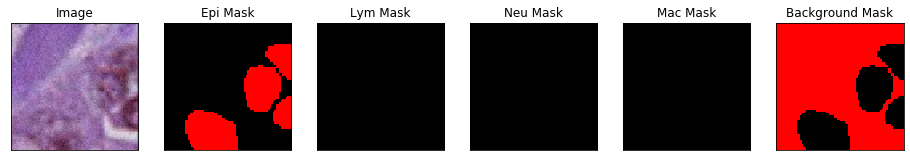

(80, 80, 3) (80, 80, 5)


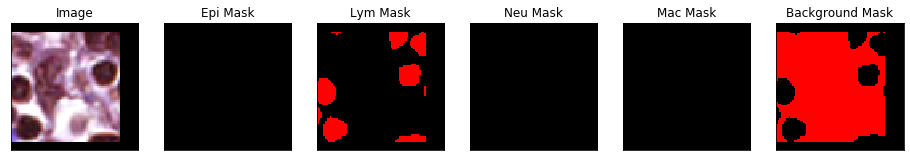

In [10]:
# After agument

dataset = Dataset(x_train_dir, y_train_dir, classes=med, augmentation=get_training_augmentation())

for i in range(3):
    image, mask = dataset[random.randrange(len(dataset))] 
    print(image.shape, mask.shape)
    visualize(
        image=image, 
        epi_mask=mask[..., 1].squeeze(),
        lym_mask=mask[..., 2].squeeze(),
        neu_mask=mask[..., 3].squeeze(),
        mac_mask=mask[..., 4].squeeze(),
        background_mask=mask[..., 0].squeeze(),
    )

### Build and compile network

In [11]:
BACKBONE = 'efficientnetb3' 
BATCH_SIZE =  128 #128
CLASSES = ['Epithelial', 'Lymphocyte', 'Neutrophil', 'Macrophage'] 
LR = 1e-4   # 1e-4(0.0001)
EPOCHS = 300

preprocess_input = sm.get_preprocessing(BACKBONE)


# Define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
print("Classes: ", n_classes)
activation = 'sigmoid' if n_classes == 1 else 'softmax'


# Create model
model = None
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation) # Train all layers

# Define optomizer
optim = keras.optimizers.Adam(LR)

# multiplication factor for computing loss
class_weight_array = np.array([0.5, 0.5, 2, 2])
#class_weight_array = np.array([0.25, 0.25, 2, 2])

# calc loss over the 4 classes
class_index_array = np.array([1,2,3,4]) 


dice_loss = sm.losses.DiceLoss(class_weights = class_weight_array, class_indexes = class_index_array)
jacard_loss = sm.losses.JaccardLoss(class_weights = class_weight_array, class_indexes = class_index_array)
focal_loss = sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0, class_indexes = class_index_array)

# Initial loss
#total_loss = dice_loss + (1 * focal_loss)

# Mod 1
total_loss = (1 * focal_loss) + (1 * jacard_loss) # best combination

# Define metrics
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Compile model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)
model.summary() 

Classes:  5
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
________________________________________________________________________________

In [12]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES,
    #augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES ,
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, patchsize, patchsize, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, patchsize, patchsize, n_classes)


# Define callbacks for learning rate scheduling, logging and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('{}/{}.h5'.format(log_path, experiment_name), monitor='val_iou_score', save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', factor=0.1, verbose=1, patience=5, mode='max'), ## new_lr = lr * factor
    keras.callbacks.EarlyStopping(monitor='val_iou_score', min_delta=0, verbose=1, patience=8, mode='max', restore_best_weights=True),
    keras.callbacks.CSVLogger('{}/training.csv'.format(log_path))
]


# Test train loader
x , y = next(iter(valid_dataloader))
print(x.shape, y.shape)

(128, 80, 80, 3) (128, 80, 80, 5)


### Train model

In [24]:
# Train model

start_time = time.time()


history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),  # val samples = batch size * no of steps
)

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))

/home/hasib/anaconda3/envs/isbi2020/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/300


InvalidArgumentError:  ConcatOp : Dimensions of inputs should match: shape[0] = [128,6,6,1536] vs. shape[1] = [128,5,5,816]
	 [[node decoder_stage0_concat/concat (defined at /home/hasib/anaconda3/envs/isbi2020/lib/python3.6/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_keras_scratch_graph_100091]

Function call stack:
keras_scratch_graph


In [ ]:
# Plot training & validation loss values
# b, g, r, y, o, -g, -m,

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(history.history['loss'],linewidth=4)
plt.plot(history.history['val_loss'],linewidth=4)
plt.title('{} loss'.format(experiment_name))
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)

# Plot training & validation iou_score values

plt.subplot(132)
plt.plot(history.history['iou_score'],linewidth=4)
plt.plot(history.history['val_iou_score'],linewidth=4)
plt.title('{} IOU score'.format(experiment_name))
#plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values

plt.subplot(133)
plt.plot(history.history['f1-score'],linewidth=4)
plt.plot(history.history['val_f1-score'],linewidth=4)
plt.title('{} F1 score'.format(experiment_name))
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.savefig('{}/{}_graph.png'.format(log_path, experiment_name), dpi=300)
plt.show()

#### Model Evaluation

In [ ]:
# Validation data is test data here

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES,
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
#x, y = next(iter(test_dataloader))
#x.shape, y.shape

In [ ]:
# Load best weights
#model=None
model.load_weights('{}/{}.h5'.format(log_path, experiment_name))

#import efficientnet.tfkeras
#from tensorflow.keras.models import load_model
#model = None
#model = load_model('{}/{}.h5'.format(log_path, experiment_name), compile=False)
print("Model loaded")


# Run on validation set
scores = model.evaluate_generator(test_dataloader, verbose=1)


mean_scores = []

# Print scores
print("Loss: {:.5}".format(scores[0]))
mean_scores.append(scores[0])

for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))
    mean_scores.append(value)


#### Compute mean PQ on validation set

In [ ]:
pqs = []
pqs_f = []

for i in tqdm(range(len(test_dataset))):
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    gt_mask = np.argmax(gt_mask.squeeze(), axis=-1)
    pr_mask = np.argmax(pr_mask.squeeze(), axis=-1)
    
    # Post processing to refine predictions
    pred_filt = cv2.medianBlur(pr_mask.astype(np.uint8), 5)
    pred_filt = pred_filt.astype(np.uint8)
    
    pq = Panoptic_quality(gt_mask, pr_mask)
    pqf = Panoptic_quality(gt_mask, pred_filt)
    
    pqs.append(pq)
    pqs_f.append(pqf)
    

pqs = np.mean(np.array(pqs))
pqs_f = np.mean(np.array(pqs_f))

mean_scores.append(pqs)
mean_scores.append(pqs_f)

print("Mean PQ without filer: {:.3}".format( pqs))
print("Mean PQ without filer: {:.3}".format( pqs_f))

| CFG | Loss   |PQ   |IoU   |F1   | Notes |
|------|------|------|------|------|------|
|   unet-dtvpl96-exp-1 | 0.89| 0.549, 0.555| 0.82| 0.85| weights [0.5, 0.5, 2, 2], no aug and preprocess, lr10-4, total_loss = (1 * focal_loss) + (1 * dice_loss)|
|   unet-dtvpl96-exp-2 | 0.45| 0.55, 0.56| 0.82| 0.85| weights [0.5, 0.5, 2, 2] no aug and no preprocess, lr10-4, total_loss = (1 * focal_loss) + (0.5 * jacard_loss) Third BEST|
|   fpn-dtvpl96-exp-1 | 0.20| 0.55, 0.56| 0.82| 0.85| weights [0.5, 0.5, 2, 2] no aug and no preprocess, lr10-4, effnetb3, total_loss = (1 * focal_loss) + (0.5 * jacard_loss)|
|   unet-dtvpl96-exp-3 | 0.45| 0.54, 0.545| 0.81| 0.85| weights [0.5, 0.5, 2, 2] no aug and no preprocess, lr10-4, total_loss = (1 * focal_loss) + (0.5 * jacard_loss)|
|   unet-dtvpl96-exp-4 | 0.90| 0.56, 0.57| 0.80| 0.84| weights [0.5, 0.5, 2, 2] no aug and no preprocess, lr10-4, total_loss = (1 * focal_loss) + (1 * jacard_loss) |
|   unet-dtvpl96-exp-5 | 0.90| 0.36, 0.37| 0.67| 0.72| weights [0.5, 0.5, 2, 2] no aug and no preprocess weights NONE, lr10-4, total_loss = (1 * focal_loss) + (1 * jacard_loss)
|   unet-dtvpl96-exp-6-full | 0.90| 0.57, 0.57| 0.84| 0.87| weights [0.5, 0.5, 2, 2] no aug and no preprocess weights none, lr10-4, total_loss = (1 * focal_loss) + (1 * jacard_loss)
| **  unet-dtvpl96-exp-7 ** | 0.90| 0.56, 0.57| 0.84| 0.87| weights [0.5, 0.5, 2, 2] no aug and no preprocess monitor val_iou, lr10-4, total_loss = (1 * focal_loss) + (1 * jacard_loss) BEST|
| ----|
|   unet-1 | XX| XX, XX| XX| XX| weights [0.5, 0.5, 2, 2] no aug and no preprocess monitor val_iou, lr10-4, total_loss = (1 * focal_loss) + (1 * jacard_loss)|

#### Email logs

In [ ]:
from pynotify import send_email, send_email_with_attachment

# loss, iou, f1 and pq
vals = [sc for sc in mean_scores]

files = ['{}/{}_graph.png'.format(log_path, experiment_name)]

subject = "Experiment results"
message = "Loss: {:.3}".format(vals[0]) + " PQ no MedFil: {:.3}".format(vals[3]) + " PQ with MedFil: {:.3}".format(vals[4]) + " IOU: {:.3}".format(vals[1]) + " F1: {:.3}".format(vals[2])

dest = "hasibzunair@gmail.com" 

# sends an email
send_email_with_attachment(dest, files, subject, message)

#### Visualization of results on test dataset

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    print(image.shape, gt_mask.shape, pr_mask.shape)
    
    gt_mask = np.argmax(gt_mask.squeeze(), axis=-1)
    pr_mask = np.argmax(pr_mask.squeeze(), axis=-1)
    print("Uniques in label and predicted", np.unique(gt_mask), np.unique(pr_mask))
    
    visualize(
        image=denormalize(image.squeeze()),
        #image= image.squeeze(),
        gt_mask = gt_mask,
        pr_mask = pr_mask
    )

In [ ]:
print("Done!")